In [1]:
from ai import ai_abs_dls, ai14s
from marubatsu import Marubatsu

mb = Marubatsu()
eval_params = {"minimax": True}
result = ai_abs_dls(mb, maxdepth=9, eval_func=ai14s, eval_params=eval_params, 
                    use_tt=True, analyze=True)
tt = result["tt"]

In [2]:
mb = Marubatsu()
mb.move(1, 1)
mb.move(0, 0)
mb.move(1, 0)
print(mb)
print(tt[mb.board_to_str()][2])

mb = Marubatsu()
mb.move(1, 1)
mb.move(2, 0)
mb.move(2, 1)
print(mb)
print(tt[mb.board_to_str()][2])

mb = Marubatsu()
mb.move(1, 1)
mb.move(2, 2)
mb.move(1, 2)
print(mb)
print(tt[mb.board_to_str()][2])

Turn x
xO.
.o.
...

(1, 2)
Turn x
..x
.oO
...

(1, 2)
Turn x
...
.o.
.Ox

(1, 2)


In [3]:
def calc_same_boardtexts(mb, move=None):
    data = [ [ 0,  0,  1, 1, -1,  0,  1,  0, -1, 0,  1,  0],
             [ 1, -1,  0, 1,  0, -1] * 2,
             [ 1,  0, -1, 0,  1,  0,  0,  0,  1, 1, -1,  0],
             [ 1, -1,  0, 0,  0,  1] * 2,
             [ 0,  1,  0, 1,  0, -1] * 2,
             [ 1,  0, -1, 1, -1,  0] * 2,
             [ 0,  0,  1, 0,  1,  0] * 2, ]
    if move is None:
        boardtexts = set([mb.board_to_str()])
    else:
        boardtexts = set([(mb.board_to_str(), move)])
    for xa, xb, xc, ya, yb, yc, xa2, xb2, xc2, ya2, yb2, yc2 in data:
        txt = ""
        for x in range(mb.BOARD_SIZE):
            for y in range(mb.BOARD_SIZE):
                txt += mb.board[xa * 2 + xb * x + xc * y][ya * 2 + yb * x + yc * y]
        if move is None:
            boardtexts.add(txt)
        else:
            x, y = move
            x, y = xa2 * 2 + xb2 * x + xc2 * y, ya2 * 2 + yb2 * x + yc2 * y
            boardtexts.add((txt, (x, y)))
    return boardtexts

In [4]:
mb = Marubatsu()
mb.move(1, 1)
mb.move(0, 0)
mb.move(1, 0)
boardtexts = calc_same_boardtexts(mb, (1, 2))
for boardtext, move in boardtexts:
    print(boardtext, move)

.ox.o.... (2, 1)
...oo.x.. (1, 2)
....oo..x (1, 0)
....o.xo. (0, 1)
....o..ox (0, 1)
x..oo.... (1, 2)
xo..o.... (2, 1)
..x.oo... (1, 0)


In [5]:
from ai import ai_by_mmscore, dprint
from copy import deepcopy

@ai_by_mmscore
def ai_abs_dls(mb, debug=False, timelimit_pc=None, maxdepth=1, eval_func=None,
               eval_params={}, use_tt=False, tt=None):           
    count = 0
    def ab_search(mborig, depth, tt, alpha=float("-inf"), beta=float("inf")):
        nonlocal count
        if timelimit_pc is not None and perf_counter() >= timelimit_pc:
            raise RuntimeError("time out")
        
        count += 1
        if mborig.status != Marubatsu.PLAYING or depth == maxdepth:
            return eval_func(mborig, calc_score=True, **eval_params)
        
        if use_tt:
            boardtxt = mborig.board_to_str()
            if boardtxt in tt:
                lower_bound, upper_bound, _ = tt[boardtxt]
                if lower_bound == upper_bound:
                    return lower_bound
                elif upper_bound <= alpha:
                    return upper_bound
                elif beta <= lower_bound:
                    return lower_bound
                else:
                    alpha = max(alpha, lower_bound)
                    beta = min(beta, upper_bound)
            else:
                lower_bound = min_score
                upper_bound = max_score
        
        alphaorig = alpha
        betaorig = beta

        legal_moves = mborig.calc_legal_moves()
        if mborig.turn == Marubatsu.CIRCLE:
            score = float("-inf")
            for x, y in legal_moves:
                mb = deepcopy(mborig)
                mb.move(x, y)
                abscore = ab_search(mb, depth + 1, tt, alpha, beta)
                if abscore > score:
                    bestmove = (x, y)
                score = max(score, abscore)
                if score >= beta:
                    break
                alpha = max(alpha, score)
        else:
            score = float("inf")
            for x, y in legal_moves:
                mb = deepcopy(mborig)
                mb.move(x, y)
                abscore = ab_search(mb, depth + 1, tt, alpha, beta)
                if abscore < score:
                    bestmove = (x, y)
                score = min(score, abscore)
                if score <= alpha:
                    break
                beta = min(beta, score)   
            
#        from util import calc_same_boardtexts

        if use_tt:
            boardtxtlist = calc_same_boardtexts(mborig, bestmove)
            if score <= alphaorig:
                upper_bound = score
            elif score < betaorig:
                lower_bound = score
                upper_bound = score
            else:
                lower_bound = score
            for boardtxt, move in boardtxtlist:
                tt[boardtxt] = (lower_bound, upper_bound, move)
        return score
                
    min_score = float("-inf")
    max_score = float("inf")
    
    if tt is None:
        tt = {}
    score = ab_search(mb, depth=0, tt=tt, alpha=min_score, beta=max_score)
    dprint(debug, "count =", count)
    return score, count

In [6]:
mb = Marubatsu()
eval_params = {"minimax": True}
result = ai_abs_dls(mb, maxdepth=9, eval_func=ai14s, eval_params=eval_params, 
                    use_tt=True, analyze=True)
tt = result["tt"]
bestmove = result["bestmove"]
PV = []
while mb.status == Marubatsu.PLAYING:
    PV.append(bestmove)
    print(bestmove)
    x, y = bestmove
    if mb.board[x][y] != Marubatsu.EMPTY:
        print("そのマスには着手済みです")
        break
    mb.move(x, y)
    print(mb)
    boardtxt = mb.board_to_str()
    if boardtxt in tt:
        _, _, bestmove = tt[boardtxt]
    elif mb.status != Marubatsu.PLAYING:
        break
print(PV)

(1, 2)
Turn x
...
...
.O.

(2, 2)
Turn o
...
...
.oX

(2, 1)
Turn x
...
..O
.ox

(1, 1)
Turn o
...
.Xo
.ox

(0, 0)
Turn x
O..
.xo
.ox

(0, 2)
Turn o
o..
.xo
Xox

(2, 0)
Turn x
o.O
.xo
xox

(1, 0)
Turn o
oXo
.xo
xox

(0, 1)
winner draw
oxo
Oxo
xox

[(1, 2), (2, 2), (2, 1), (1, 1), (0, 0), (0, 2), (2, 0), (1, 0), (0, 1)]


In [7]:
@ai_by_mmscore
def ai_abs_dls(mb, debug=False, timelimit_pc=None, maxdepth=1, eval_func=None,
               eval_params={}, use_tt=False, tt=None, tt_for_mo=None):           
    count = 0
    def ab_search(mborig, depth, tt, alpha=float("-inf"), beta=float("inf")):
        nonlocal count
        if timelimit_pc is not None and perf_counter() >= timelimit_pc:
            raise RuntimeError("time out")
        
        count += 1
        if mborig.status != Marubatsu.PLAYING or depth == maxdepth:
            return eval_func(mborig, calc_score=True, **eval_params)
        
        if use_tt:
            boardtxt = mborig.board_to_str()
            if boardtxt in tt:
                lower_bound, upper_bound, _ = tt[boardtxt]
                if lower_bound == upper_bound:
                    return lower_bound
                elif upper_bound <= alpha:
                    return upper_bound
                elif beta <= lower_bound:
                    return lower_bound
                else:
                    alpha = max(alpha, lower_bound)
                    beta = min(beta, upper_bound)
            else:
                lower_bound = min_score
                upper_bound = max_score
        
        alphaorig = alpha
        betaorig = beta

        legal_moves = mborig.calc_legal_moves()
        if tt_for_mo is not None:
            if not use_tt:            
                boardtxt = mborig.board_to_str()
            if boardtxt in tt_for_mo:
                _, _, bestmove = tt_for_mo[boardtxt]
                index = legal_moves.index(bestmove)
                legal_moves[0], legal_moves[index] = legal_moves[index], legal_moves[0]
        if mborig.turn == Marubatsu.CIRCLE:
            score = float("-inf")
            for x, y in legal_moves:
                mb = deepcopy(mborig)
                mb.move(x, y)
                abscore = ab_search(mb, depth + 1, tt, alpha, beta)
                if abscore > score:
                    bestmove = (x, y)
                score = max(score, abscore)
                if score >= beta:
                    break
                alpha = max(alpha, score)
        else:
            score = float("inf")
            for x, y in legal_moves:
                mb = deepcopy(mborig)
                mb.move(x, y)
                abscore = ab_search(mb, depth + 1, tt, alpha, beta)
                if abscore < score:
                    bestmove = (x, y)
                score = min(score, abscore)
                if score <= alpha:
                    break
                beta = min(beta, score)   
            
#        from util import calc_same_boardtexts

        if use_tt:
            boardtxtlist = calc_same_boardtexts(mborig, bestmove)
            if score <= alphaorig:
                upper_bound = score
            elif score < betaorig:
                lower_bound = score
                upper_bound = score
            else:
                lower_bound = score
            for boardtxt, move in boardtxtlist:
                tt[boardtxt] = (lower_bound, upper_bound, move)
        return score
                
    min_score = float("-inf")
    max_score = float("inf")
    
    if tt is None:
        tt = {}
    score = ab_search(mb, depth=0, tt=tt, alpha=min_score, beta=max_score)
    dprint(debug, "count =", count)
    return score, count

In [8]:
mb = Marubatsu()
result = ai_abs_dls(mb, maxdepth=9, eval_func=ai14s, eval_params=eval_params, 
                    use_tt=True, analyze=True)
print(result["time"], result["count"], result["score"], result["candidate"])

0.09531459957361221 1175 0.0 [(0, 0), (1, 0), (2, 0), (0, 1), (1, 1), (2, 1), (0, 2), (1, 2), (2, 2)]


In [9]:
result = ai_abs_dls(mb, maxdepth=9, eval_func=ai14s, eval_params=eval_params, 
                    use_tt=True, analyze=True, tt_for_mo=result["tt"])
print(result["time"], result["count"], result["score"], result["candidate"])

0.05051949992775917 538 0.0 [(0, 0), (1, 0), (2, 0), (0, 1), (1, 1), (2, 1), (0, 2), (1, 2), (2, 2)]


In [10]:
from time import perf_counter

def ai_ab_iddfs(mb, debug=False, timelimit=10, eval_func=None, eval_params={},
               use_tt=True, share_tt=True, analyze=False, moveordering=True):
    starttime = perf_counter()
    timelimit_pc = starttime + timelimit
    if moveordering:
        use_tt = True
        share_tt = True
        tt_for_mo = {}
    else:
        tt_for_mo = None
    bestmove = mb.calc_legal_moves()[0]
    totalcount = 0
    resultlist = []
    for maxdepth in range(9 - mb.move_count):
        try:
            result = ai_abs_dls(mb, maxdepth=maxdepth, timelimit_pc=timelimit_pc,
                                eval_func=eval_func, eval_params=eval_params,
                                use_tt=use_tt, share_tt=share_tt,
                                analyze=analyze or moveordering, tt_for_mo=tt_for_mo)
        except RuntimeError:
            dprint(debug, "time out")
            break
        if moveordering:
            tt_for_mo = result["tt"]
        totaltime = perf_counter() - starttime
        resultlist.append(result)
        if analyze or moveordering:
            candidate = result["candidate"]
            bestmove = result["bestmove"]
            count = result["count"]
            time = result["time"]
            totalcount += count
            dprint(debug, f"maxdepth: {maxdepth}, time: {time:6.2f}/{totaltime:6.2f} ms, count {count:5}/{totalcount:5}, bestmove: {bestmove}, candidate: {candidate}")
        else:
            bestmove = result
            dprint(debug, f"maxdepth: {maxdepth}, time: {totaltime:6.2f} ms, bestmove: {bestmove}")
    dprint(debug, f"totaltime: {perf_counter() - starttime: 6.2f} ms")
    if analyze:
        return resultlist
    else:
        return bestmove

In [11]:
print(ai_ab_iddfs(mb, timelimit=10, debug=True, eval_func=ai14s,
                  eval_params=eval_params, analyze=False, moveordering=False))

maxdepth: 0, time:   0.00 ms, bestmove: (1, 1)
maxdepth: 1, time:   0.00 ms, bestmove: (1, 1)
maxdepth: 2, time:   0.01 ms, bestmove: (1, 1)
maxdepth: 3, time:   0.04 ms, bestmove: (1, 1)
maxdepth: 4, time:   0.10 ms, bestmove: (1, 1)
maxdepth: 5, time:   0.21 ms, bestmove: (1, 1)
maxdepth: 6, time:   0.27 ms, bestmove: (1, 1)
maxdepth: 7, time:   0.34 ms, bestmove: (1, 2)
maxdepth: 8, time:   0.42 ms, bestmove: (0, 0)
totaltime:   0.42 ms
(0, 0)


In [12]:
resultlist = ai_ab_iddfs(mb, timelimit=10, debug=True, eval_func=ai14s,
                         eval_params=eval_params, analyze=True, moveordering=False)
print(resultlist)

maxdepth: 0, time:   0.00/  0.00 ms, count     9/    9, bestmove: (1, 1), candidate: [(1, 1)]
maxdepth: 1, time:   0.01/  0.01 ms, count    33/   42, bestmove: (1, 1), candidate: [(1, 1)]
maxdepth: 2, time:   0.01/  0.02 ms, count    81/  123, bestmove: (1, 1), candidate: [(1, 1)]
maxdepth: 3, time:   0.03/  0.04 ms, count   206/  329, bestmove: (1, 1), candidate: [(1, 1)]
maxdepth: 4, time:   0.03/  0.07 ms, count   431/  760, bestmove: (1, 1), candidate: [(1, 1)]
maxdepth: 5, time:   0.06/  0.13 ms, count   927/ 1687, bestmove: (1, 1), candidate: [(1, 1)]
maxdepth: 6, time:   0.17/  0.30 ms, count  1121/ 2808, bestmove: (1, 1), candidate: [(1, 1)]
maxdepth: 7, time:   0.10/  0.39 ms, count  1161/ 3969, bestmove: (1, 2), candidate: [(0, 0), (1, 0), (2, 0), (0, 1), (1, 1), (2, 1), (0, 2), (1, 2), (2, 2)]
maxdepth: 8, time:   0.07/  0.46 ms, count  1175/ 5144, bestmove: (2, 0), candidate: [(0, 0), (1, 0), (2, 0), (0, 1), (1, 1), (2, 1), (0, 2), (1, 2), (2, 2)]
totaltime:   0.46 ms
[{'ca

In [13]:
resultlist_mo = ai_ab_iddfs(mb, timelimit=10, debug=True, eval_func=ai14s,
                            eval_params=eval_params, analyze=True, moveordering=True)

maxdepth: 0, time:   0.00/  0.00 ms, count     9/    9, bestmove: (1, 1), candidate: [(1, 1)]
maxdepth: 1, time:   0.01/  0.01 ms, count    33/   42, bestmove: (1, 1), candidate: [(1, 1)]
maxdepth: 2, time:   0.01/  0.02 ms, count    66/  108, bestmove: (1, 1), candidate: [(1, 1)]
maxdepth: 3, time:   0.03/  0.05 ms, count   162/  270, bestmove: (1, 1), candidate: [(1, 1)]
maxdepth: 4, time:   0.02/  0.07 ms, count   272/  542, bestmove: (1, 1), candidate: [(1, 1)]
maxdepth: 5, time:   0.03/  0.10 ms, count   446/  988, bestmove: (1, 1), candidate: [(1, 1)]
maxdepth: 6, time:   0.04/  0.14 ms, count   578/ 1566, bestmove: (1, 1), candidate: [(1, 1)]
maxdepth: 7, time:   0.03/  0.17 ms, count   530/ 2096, bestmove: (1, 2), candidate: [(0, 0), (1, 0), (2, 0), (0, 1), (1, 1), (2, 1), (0, 2), (1, 2), (2, 2)]
maxdepth: 8, time:   0.03/  0.20 ms, count   533/ 2629, bestmove: (0, 0), candidate: [(0, 0), (1, 0), (2, 0), (0, 1), (1, 1), (2, 1), (0, 2), (1, 2), (2, 2)]
totaltime:   0.20 ms


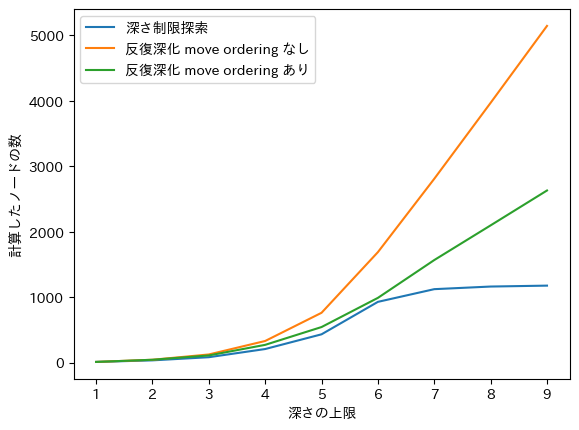

In [14]:
import matplotlib.pyplot as plt

countlist = []
totalcount = 0
totalcountlist = []
for result in resultlist:
    count = result["count"]
    totalcount += count
    countlist.append(count)
    totalcountlist.append(totalcount)

totalcount_mo = 0
totalcountlist_mo = []
for result in resultlist_mo:
    count_mo = result["count"]
    totalcount_mo += count_mo
    totalcountlist_mo.append(totalcount_mo)

maxdepthlist = range(1, 10)
plt.plot(maxdepthlist, countlist, label="深さ制限探索")
plt.plot(maxdepthlist, totalcountlist, label="反復深化 move ordering なし")
plt.plot(maxdepthlist, totalcountlist_mo, label="反復深化 move ordering あり")
plt.xlabel("深さの上限")
plt.ylabel("計算したノードの数")
plt.legend()